### 1. Necessary Imports

In [5]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from scipy.signal import find_peaks, peak_widths
import astropy.units as u
import numpy as np
import pandas as pd
from collections import defaultdict
import math
from astropy.table import QTable, Table, Column

### 2. Fetch Data

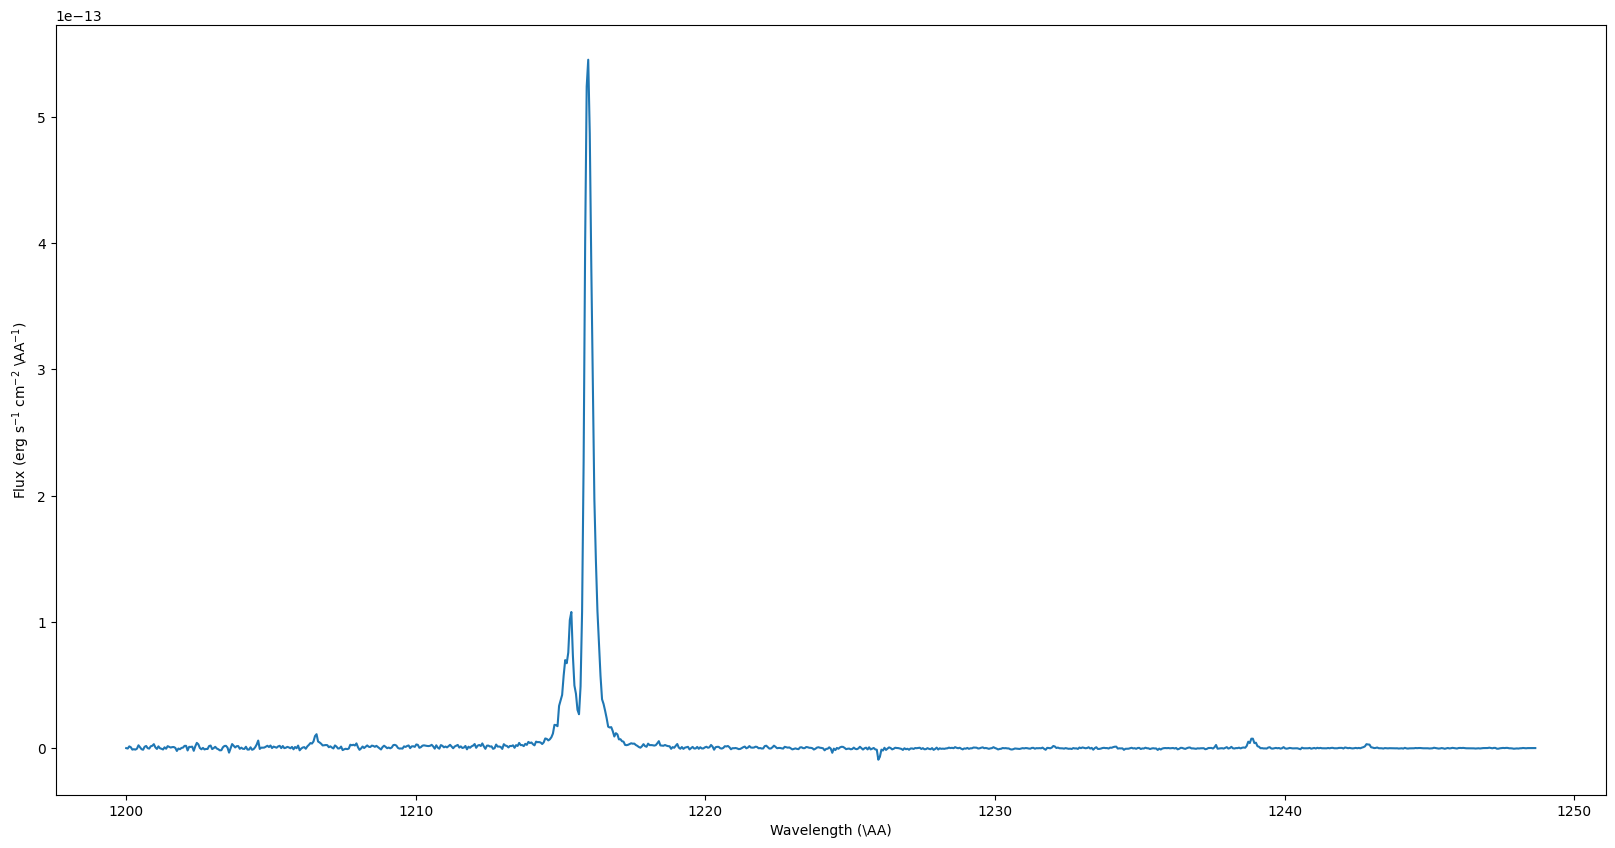

In [29]:
data = fits.getdata('hlsp_muscles_hst_stis_gj832_g140m_v22_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1200
plt.figure(figsize=(20,10))

plt.plot(w[mask], f[mask])

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

### 3. Find Peaks

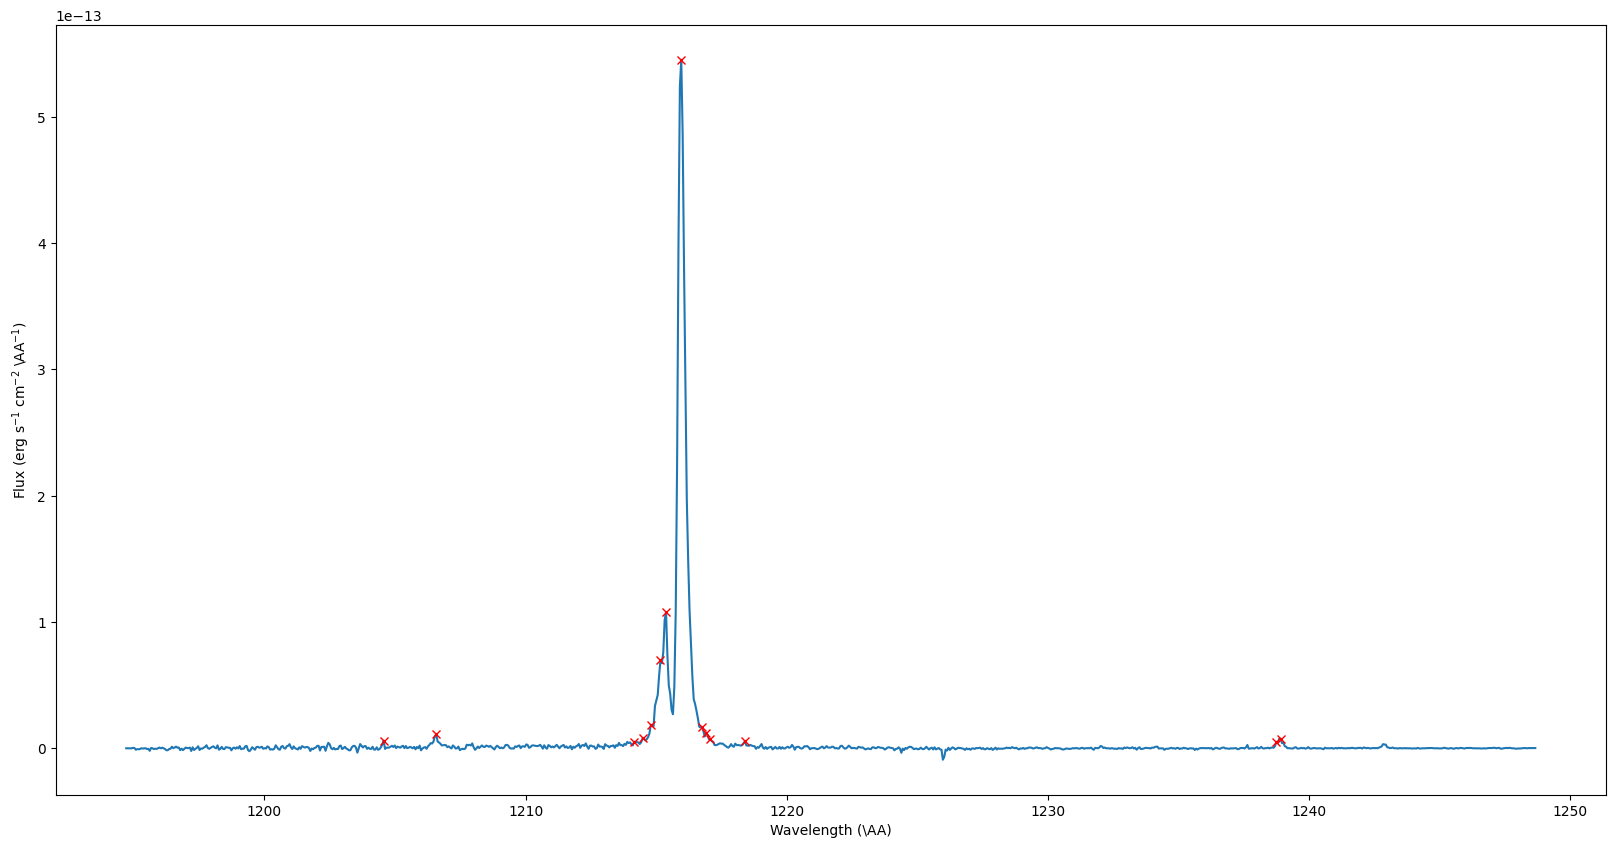

Peak 0: 1204.5630002059047
Peak 1: 1206.5770001821224
Peak 2: 1214.1560000926258
Peak 3: 1214.4740000888708
Peak 4: 1214.7920000851157
Peak 5: 1215.1630000807347
Peak 6: 1215.3750000782313
Peak 7: 1215.958000071347
Peak 8: 1216.7530000619593
Peak 9: 1216.9120000600817
Peak 10: 1217.071000058204
Peak 11: 1218.3960000425577
Peak 12: 1238.7479998022313
Peak 13: 1238.9069998003538


In [7]:
# Find peaks
peaks, properties = find_peaks(f[mask], height = sum(f[mask])/len(f[mask]), width = 0)

plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.plot(w[mask][peaks], f[mask][peaks], "xr")
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

# All peaks!
count = 0
for peak in w[mask][peaks]:
    print(f"Peak {count}: {peak}")
    count+=1

### 4. Load Rest Lam Data

In [9]:
# Get rest data
data = pd.read_csv("../DEM_goodlinelist .csv")
df = pd.DataFrame(data)
print(df)

       Ion  Wavelength Likelihood to measure  Log Formation Temperature
0     S VI     933.397                Medium                        5.3
1    N III     989.787                Medium                        4.9
2    N III     991.495                Medium                        4.9
3    N III     991.564                Medium                        4.9
4    Ne VI     999.182                Medium                        5.6
5     O VI    1032.914                Medium                        5.5
6     O VI    1037.615                Medium                        5.5
7   Fe XIX    1118.057                   Low                        6.9
8     Ne V    1145.596                Medium                        5.5
9    C III    1174.935                  High                        4.9
10   C III    1175.265                  High                        4.9
11   C III    1175.592                  High                        4.9
12   C III    1175.713                  High                    

### 5. Calculate Doppler Shift

Find two lines that have a dotted red line(rest lam) and green line(peak) "close" to eachother, and write down the rest wavelength and peak wavelength using information in steps 3 and 4.
If two lines are "blended",take an average of the two blended peak's doppler shifts, and use that average in the doppler calculation.

(1200.0, 1250.0)

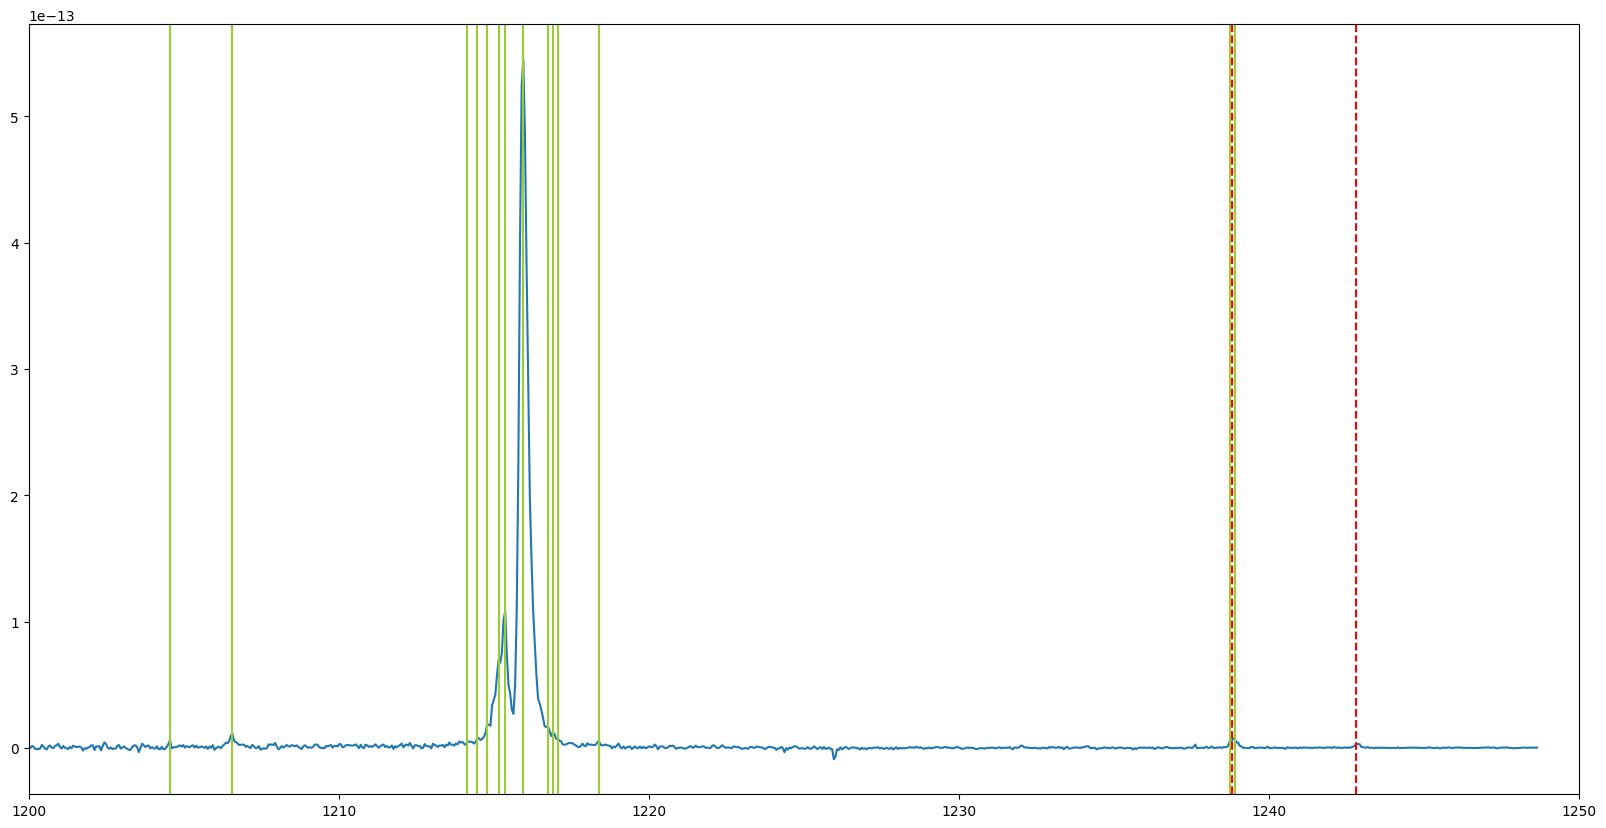

In [10]:
# mask = w > 1250
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

for line in df['Wavelength']:
    if(line > 1220):
        plt.axvline(x = line, color = 'red', label = 'axvline - full height', linestyle = "--")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')

plt.xlim([1200, 1250]) # add +50

    Observed and rest wavelengths for calculation:
    1238.7479998022313 1238.821

In [13]:
u_rest_lam = 1238.821 * u.AA 
u_obs_lam = 1238.7479998022313 * u.AA 
dv = u_obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(u_rest_lam))

print(f"Doppler shift: {dv}")


Doppler shift: -17.665916806016195 km / s


### 6. Calculate Peak Width

Calculate an estimate for the peak width, and use that estimate to find the actual peak width

Peak width based on grating: G140L L - 3.5 Angstroms, E140M - 0.35 Angstroms

Calculate the angstrom_to_pixels constant by calculating the difference between each wavelength value and use that constant value to calculate the peak width in pixels

Current peak estimate: 2.484443235668749
Peak width: 0.35
Flux range: 0.7
Angstroms_to_pixels: 0.05299999937415123
Peak width in pixels: 6


(-1e-14, 1.5e-13)

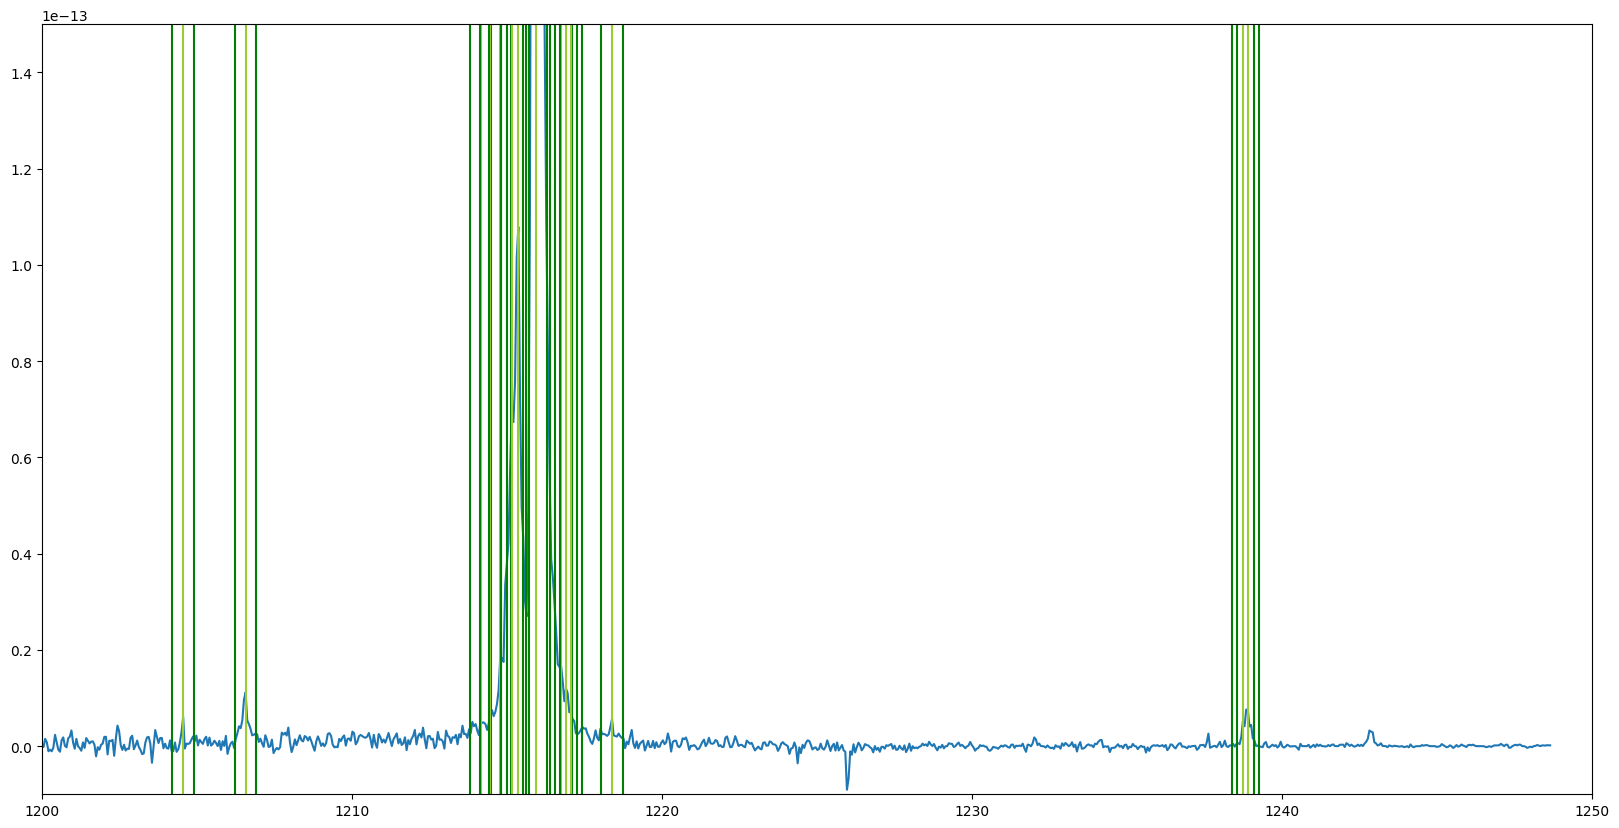

In [16]:
"""
    Peak width finder: first make a guesstimate using peak properties, then refine later
"""
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

# Make estimate
avg_peak_width = (sum(properties['widths'])/len(properties['widths']))
print(f"Current peak estimate: {avg_peak_width}")

# Refine based on estimated
peak_width = 0.35
print(f"Peak width: {peak_width}")

# Make range 
flux_range = 2*peak_width
print(f"Flux range: {flux_range}")

# Flux range in pixels
angstroms_to_pixels = w[1] - w[0] # NOTE! have to recalculate this number every time
print(f"Angstroms_to_pixels: {angstroms_to_pixels}")
peak_width_pixels = math.floor(peak_width/angstroms_to_pixels)
print(f"Peak width in pixels: {peak_width_pixels}")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')
    plt.axvline(x = peak + peak_width, color = 'green', label = 'axvline - full height')
    plt.axvline(x = peak - peak_width, color = 'green', label = 'axvline - full height')

plt.xlim([1200, 1250]) # add +60
plt.ylim([-1e-14, 1.5e-13])

In [17]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [18]:
"""
    Make a trendline based on the average flux within the mask from the left and right to the peak 
    (use if there is a lot of noise)
"""
def create_trendline(w, f, blended_line_bool):
    # Initialize variables
    length = len(w) - 1
    flux_list = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, peak_width_pixels):
        flux_list.append(f[i])
        flux_list.append(f[length-i])
        
    # Find the average flux 
    avg_flux = sum(flux_list)/len(flux_list)
    flux_array = [avg_flux for i in range(length + 1)]
           
    wavelength_array = np.array(w)
    
    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
    if blended_line_bool == True:
        plt.plot(wavelength_array, p(wavelength_array), color="blue", alpha=0.6)
    else:
        plt.plot(wavelength_array, p(wavelength_array), color="red", alpha=0.6)
    
    return p(wavelength_array) 

Flux: 2.0175779472411368e-15
Error: 2.1696727635451828e-16


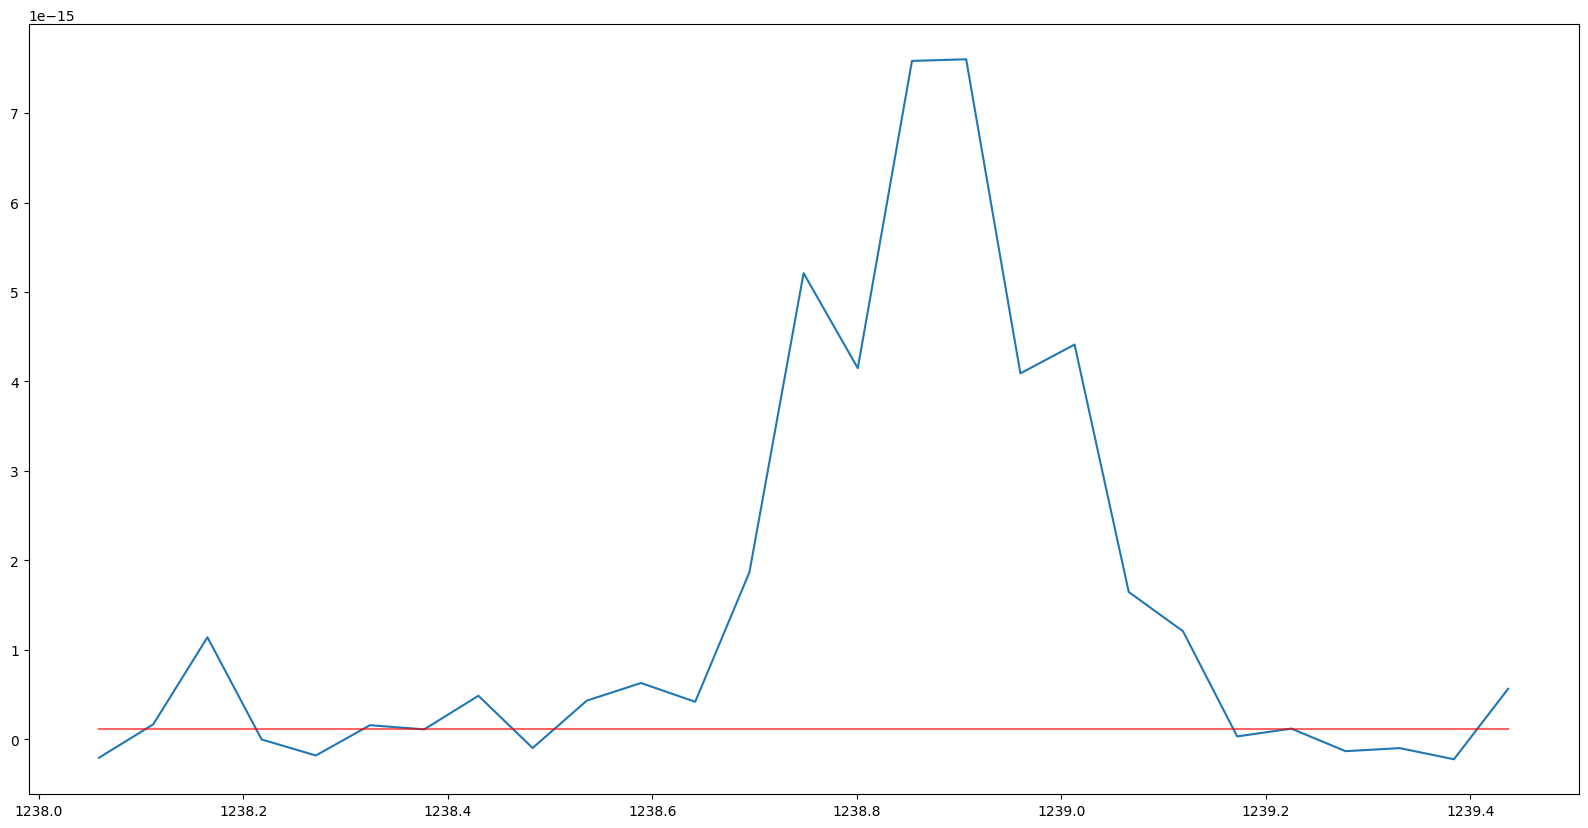

In [20]:
# Mask current peak (use this for the rest!)
wavelength_mask = (w > (w[mask][peaks][12] - flux_range)) & (w < (w[mask][peaks][12] + flux_range))
w0,w1 = wavelength_edges(w[wavelength_mask])
total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5

plt.figure(figsize=(20,10))
plt.plot(w[wavelength_mask], f[wavelength_mask])


# Continuum calculation
continuum = []
trendline = create_trendline(w[wavelength_mask], f[wavelength_mask], False) # fix 

for i in range(0, len(trendline)):
    continuum.append(trendline[i])

continuum_sumflux = np.sum(continuum*(w1-w0))


print(f"Flux: {total_sumflux - continuum_sumflux}")
print(f"Error: {sumerror}")


In [21]:
def check_in_range(val1, val2, x):
    if val1 <= x <= val2:
        return True
    else:
        return False

In [22]:
"""
    Checks if there is a blended line by seeing if the previous peak is within the current obs_lam's range
"""
def blended_line_check(previous_obs, obs_lam, iterations):
    if check_in_range(obs_lam.value - flux_range, obs_lam.value + flux_range, previous_obs.value) and (iterations != 0):
        return True
    else:
        return False

#### 7. Calculate Flux

Ion: Si III 
('Wavelength: 1206.499', 'Flux: 2.088455163699424e-15', 'Error: 4.883659969372591e-16', 'Blended line: False')
Ion: O V] 
('Wavelength: 1218.39', 'Flux: 9.916640584798367e-16', 'Error: 3.5434808619131814e-16', 'Blended line: False')
Ion: N V 
('Wavelength: 1238.821', 'Flux: 2.0175779472411368e-15', 'Error: 2.1696727635451828e-16', 'Blended line: False')
('Wavelength: 1242.804', 'Flux: 6.200670523320864e-16', 'Error: 1.4211061161144835e-16', 'Blended line: False')


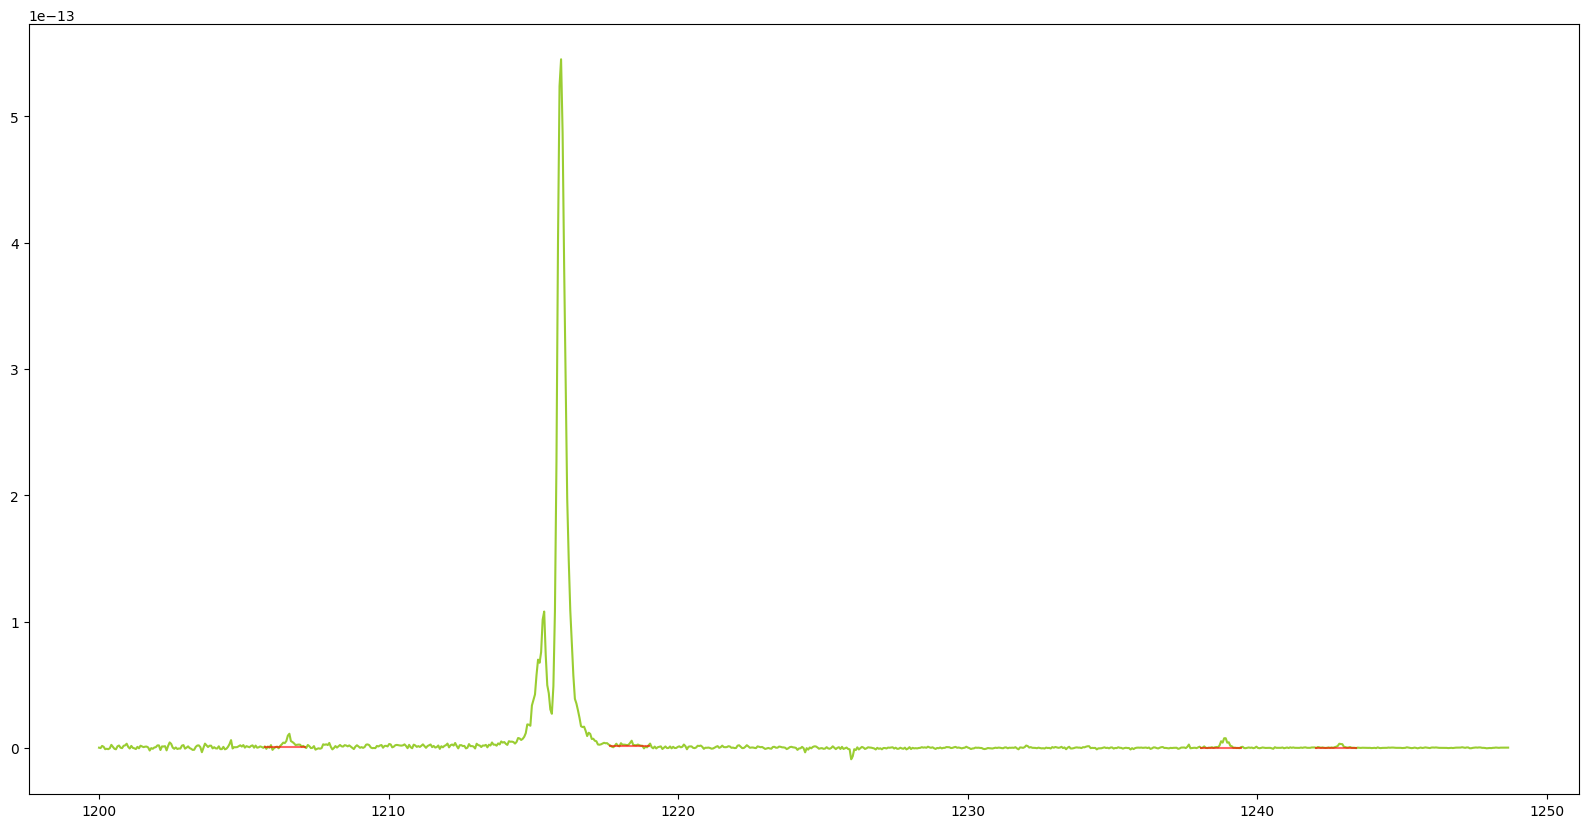

In [32]:
plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask], color="yellowgreen")

# Initializing
flux = defaultdict(list)
count = 0 
iterations = 0
previous_obs = 0 *u.AA
prev_blended_bool = False
prev_left_bound = 0

for wavelength in df['Wavelength']:
    if(wavelength > 1200) and (wavelength < 1250):     
        continuum = []
        
        # obs_lam calculation from doppler
        rest_lam = wavelength * u.AA
        obs_lam = dv.to(u.AA,  equivalencies=u.doppler_optical(rest_lam))
        
        # Check for blended lines
        blended_line_bool = blended_line_check(previous_obs, obs_lam, iterations)
        # Check if previous lam was also a blended line
        if blended_line_bool and prev_blended_bool:
            wavelength_mask = (w > prev_left_bound) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = True
        # If there is a blended line, and previous wasn't a blended line
        elif blended_line_bool:
            wavelength_mask = (w > (previous_obs.value - flux_range)) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = True
            prev_left_bound = previous_obs.value - flux_range
        # Not a blended line
        else:
            wavelength_mask = (w > (obs_lam.value - flux_range)) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = False
        
        # Compute the flux and error
        w0,w1 = wavelength_edges(w[wavelength_mask])
        total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
        sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5
        
        # Create trendline
        trendline = create_trendline(w[wavelength_mask], f[wavelength_mask], blended_line_bool)

        # Calculate the continuum
        for i in range(0, len(trendline)):
            continuum.append(trendline[i])
        continuum_sumflux = np.sum(continuum*(w1-w0))
        
        # Check if the flux is negative
        total_flux = total_sumflux - continuum_sumflux
        if total_flux <= 0:
            total_flux = sumerror * 3
            sumerror = 0
        
        # If there is a blended line
        if blended_line_bool:
            # Delete the previous flux calculation (check me!) - may need to get rid of [count-1]
            del flux[df['Ion'][count - 1]][previous_index]
            # Add the new flux calculation
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror), "Blended line: " + str(blended_line_bool)))
        # If there is not a blended line
        else:
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror),"Blended line: " + str(False)))
            
        # Update variables
        previous_obs = obs_lam
        previous_index = len(flux[df['Ion'][count]]) - 1
        iterations+=1
        
    count+=1 
    
# Printing
for ion in flux:
    print(f"Ion: {ion} ")
    for data in flux[ion]:
        print(data)

In [34]:
# Astropy tables
data_array = []

for ion in flux:
    for data in flux[ion]:
        data_array.append({"Ion": ion, "Wavelength": data[0], "Flux": data[1], "Error": data[2], "Blended line": data[3]})

t = Table(rows=data_array)
print(t)
t.write('gj-832.ecsv')

 Ion        Wavelength      ...     Blended line   
------ -------------------- ... -------------------
Si III Wavelength: 1206.499 ... Blended line: False
  O V]  Wavelength: 1218.39 ... Blended line: False
   N V Wavelength: 1238.821 ... Blended line: False
   N V Wavelength: 1242.804 ... Blended line: False
